In [1]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import lstm, time #helper libraries

Using TensorFlow backend.


In [2]:
import time
import warnings
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #print ('yo')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'r').read()
    data = f.split('\n')

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
        #print(result)

    if normalise_window:
        result = normalise_windows2(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return [x_train, y_train, x_test, y_test]

# def normalise_windows(window_data):
#     normalised_data = []
#     for window in window_data:
#         normalised_window = [((float(p) / (float(window[0]))) - 1) for p in window]
#         normalised_data.append(normalised_window)
#     return normalised_data

def normalise_windows2(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / (float(max(window)))) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs


In [3]:
#Step 1 Load Data
#X_train, y_train, X_test, y_test = lstm.load_data('sp500.csv', 50, True)
X_train, y_train, X_test, y_test = lstm.load_data('m1.csv', 7, True)

In [4]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

# model.add(Dense(
#     output_dim=256))
# model.add(Activation('linear'))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mae', optimizer='adam')
print( 'compilation time : ', time.time() - start)

compilation time :  0.05082988739013672


In [7]:
## Step 3 Train the model
model.fit(
    X_train,
    y_train,
    batch_size=64,
    nb_epoch=100,
    validation_split=0.1)

Train on 191 samples, validate on 22 samples
Epoch 1/100
191/191 [==============================] - 0s 685us/step - loss: 0.3998 - val_loss: 0.4851
Epoch 2/100
191/191 [==============================] - 0s 600us/step - loss: 0.3904 - val_loss: 0.4515
Epoch 3/100
191/191 [==============================] - 0s 468us/step - loss: 0.3790 - val_loss: 0.4155
Epoch 4/100
191/191 [==============================] - 0s 509us/step - loss: 0.3703 - val_loss: 0.3879
Epoch 5/100
191/191 [==============================] - 0s 470us/step - loss: 0.3473 - val_loss: 0.3910
Epoch 6/100
191/191 [==============================] - 0s 364us/step - loss: 0.3366 - val_loss: 0.4365
Epoch 7/100
191/191 [==============================] - 0s 695us/step - loss: 0.3281 - val_loss: 0.4584
Epoch 8/100
191/191 [==============================] - 0s 784us/step - loss: 0.3296 - val_loss: 0.3960
Epoch 9/100
191/191 [==============================] - 0s 662us/step - loss: 0.3300 - val_loss: 0.4415
Epoch 10/100
191/191 [======

191/191 [==============================] - 0s 664us/step - loss: 0.2812 - val_loss: 0.3563
Epoch 80/100
191/191 [==============================] - 0s 533us/step - loss: 0.2710 - val_loss: 0.3820
Epoch 81/100
191/191 [==============================] - 0s 530us/step - loss: 0.2789 - val_loss: 0.3806
Epoch 82/100
191/191 [==============================] - 0s 574us/step - loss: 0.2747 - val_loss: 0.3715
Epoch 83/100
191/191 [==============================] - 0s 501us/step - loss: 0.2815 - val_loss: 0.3438
Epoch 84/100
191/191 [==============================] - 0s 507us/step - loss: 0.2751 - val_loss: 0.3644
Epoch 85/100
191/191 [==============================] - 0s 577us/step - loss: 0.2782 - val_loss: 0.3993
Epoch 86/100
191/191 [==============================] - 0s 611us/step - loss: 0.2727 - val_loss: 0.3668
Epoch 87/100
191/191 [==============================] - 0s 567us/step - loss: 0.2760 - val_loss: 0.3566
Epoch 88/100
191/191 [==============================] - 0s 593us/step - loss:

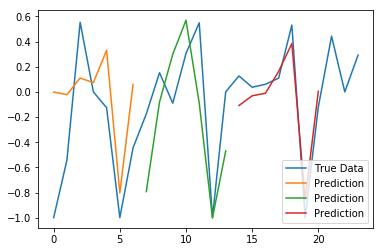

In [8]:
#Step 4 - Plot the predictions!
predictions = predict_sequences_multiple(model, X_test, 7, 7)
plot_results_multiple(predictions, y_test, 7)